# Scanpy: DiffusionPseudoTime

In [1]:
import scvelo as scv
import scanpy as sc
import velocyto as vcy
import cellrank as cr
import loompy as lp

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from pathlib import Path

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

In [5]:
# load file path from ocean
adata_infile = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/palantir_gene_leiden_aggr.h5ad'

In [6]:
# transfer the file to the scratch space
!rsync -aP $adata_infile $LOCAL/

sending incremental file list
rsync: opendir "/bil" failed: Permission denied (13)
rsync: opendir "/boot/grub2" failed: Permission denied (13)
rsync: opendir "/boot/loader/entries" failed: Permission denied (13)
dr-xr-xr-x          4,096 2023/12/13 16:28:00 .
-rw-r--r--              0 2023/12/12 10:17:15 .autorelabel
lrwxrwxrwx              7 2021/06/21 05:52:39 bin -> usr/bin
lrwxrwxrwx              7 2021/06/21 05:52:39 lib -> usr/lib
lrwxrwxrwx              9 2021/06/21 05:52:39 lib64 -> usr/lib64
lrwxrwxrwx              8 2021/06/21 05:52:39 sbin -> usr/sbin
drwxr-xr-x              0 2024/08/06 18:21:43 bil
dr-xr-xr-x          4,096 2023/12/12 13:10:25 boot
-rw-r--r--            173 2023/04/05 13:50:19 boot/.vmlinuz-4.18.0-477.10.1.el8_8.x86_64.hmac
-rw-r--r--            173 2023/08/31 10:34:04 boot/.vmlinuz-4.18.0-477.27.1.el8_8.x86_64.hmac
-rw-------      4,450,954 2023/04/05 13:51:07 boot/System.map-4.18.0-477.10.1.el8_8.x86_64
-rw-------      4,452,387 2023/08/31 10:34:19 boot/

In [ ]:
adata_pseudotime_p1 = sc.read_h5ad(adata_infile)

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


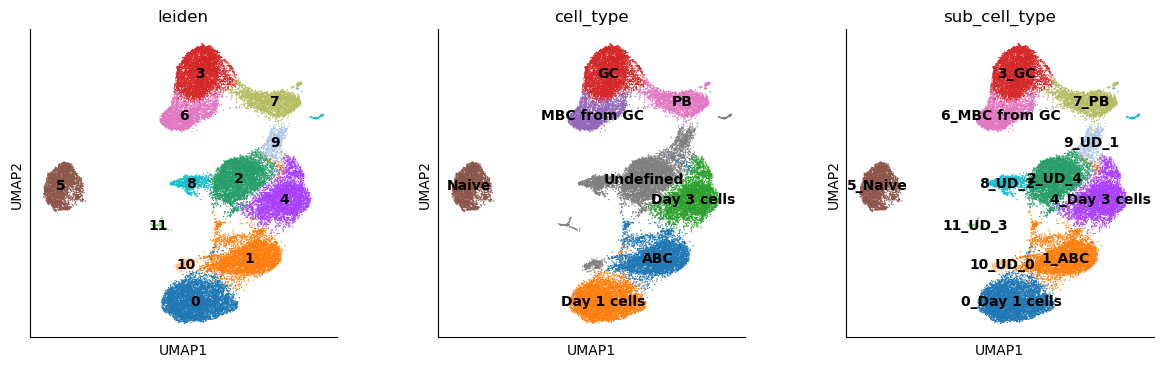

In [60]:
cluster_list = list(set(adata_pseudotime.obs.leiden))
# Annotation 1
cell_type_labels = {'5':"Naive",
              '6': "MBC from GC",
              '7':"PB",  
              '1':"ABC",
               '0':"Day 1 cells",   
              '4':"Day 3 cells",
              '3':"GC",
              '2':"Undefined",
              '8':"Undefined",
              '9':"Undefined",
              '10':"Undefined",
              '11':"Undefined"}

# add to anndata
adata_pseudotime.obs["cell_type"] = [cell_type_labels[i] for i in adata_pseudotime.obs.leiden]

# Annotation 2
annotation_2 = {'5': '5_Naive',
                '10': '10_UD_0',
                '9': '9_UD_1',
                '8': '8_UD_2',
                '3': '3_GC',
                '11': '11_UD_3',
                '1': '1_ABC',
                '0': '0_Day 1 cells',
                '7': '7_PB',
                '4': '4_Day 3 cells',
                '6': '6_MBC from GC',
                '2': '2_UD_4'}
adata_pseudotime.obs["sub_cell_type"] = [annotation_2[i] for i in adata_pseudotime.obs.leiden]
sc.pl.umap(adata_pseudotime, color=['leiden', 'cell_type','sub_cell_type'],legend_loc='on data')

In [61]:
adata_pseudotime.X = adata_pseudotime.layers['counts']

In [62]:
adata_pseudotime

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'cell_type', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'cell_type_colors', 'sub_cell_type_colors'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features'
    varm: 'topic_feature_activations', 'to

# Palantir 
## Pseudotime gives relative distance from the inital cell

#### Pre-process to select highly variable genes + genes of interest

In [63]:
import palantir

In [64]:
def feature_selection(adata, gene_list = None):
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger',n_top_genes=1500) 
    # MODIFY FILTERED_GENES TO ADD GENES OF INTEREST
    # Overriding the bool_list to include TF of interest
    if gene_list is not None:
        for gene in gene_list:
            if adata.var['highly_variable'][gene] == False:
                adata.var['highly_variable'][gene] = True
    #subset the anndata for faster downstream calculations 
    adata = adata[:, adata.var.highly_variable]
    return adata

In [65]:
TFs_of_importance = ["BATF","IRF8","SPIB","PRDM1","IRF4"]
marker_list = ["IL10", "AICDA", "IL4R", "FCER2", "BCL6", "JUN", "CD69", "JCHAIN", "CD27", "CD38", "XBP1", "MZB1", "MKI67"]
TF_perturb_list = ["BATF3","EGR1","FOS","IKZF1","IRF1","JUNB","JUND","MEF2A","MEF2C","MYB","NFATC1","NFATC2","NFIL3","NFKB1","NFKB2","PAX5","RUNX1","SP3","SPI1","STAT1","STAT5A","TCF12","VDR","XBP1","ZBTB7A"]
gene_list = list(set(marker_list).union(set(TF_perturb_list)).union(set(TFs_of_importance)))
adata_pseudotime = feature_selection(adata_pseudotime, gene_list) 

In [66]:
# check if new adata has var names of interest from the TFs_of_importance list
print(adata_pseudotime.var.highly_variable[TFs_of_importance])
adata_pseudotime


BATF     True
IRF8     True
SPIB     True
PRDM1    True
IRF4     True
Name: highly_variable, dtype: bool


View of AnnData object with n_obs × n_vars = 32418 × 1533
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'cell_type', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'cell_type_colors', 'sub_cell_type_colors', 'hvg'
    obsm: 'X_joint_umap_features', 'X_topic_composit

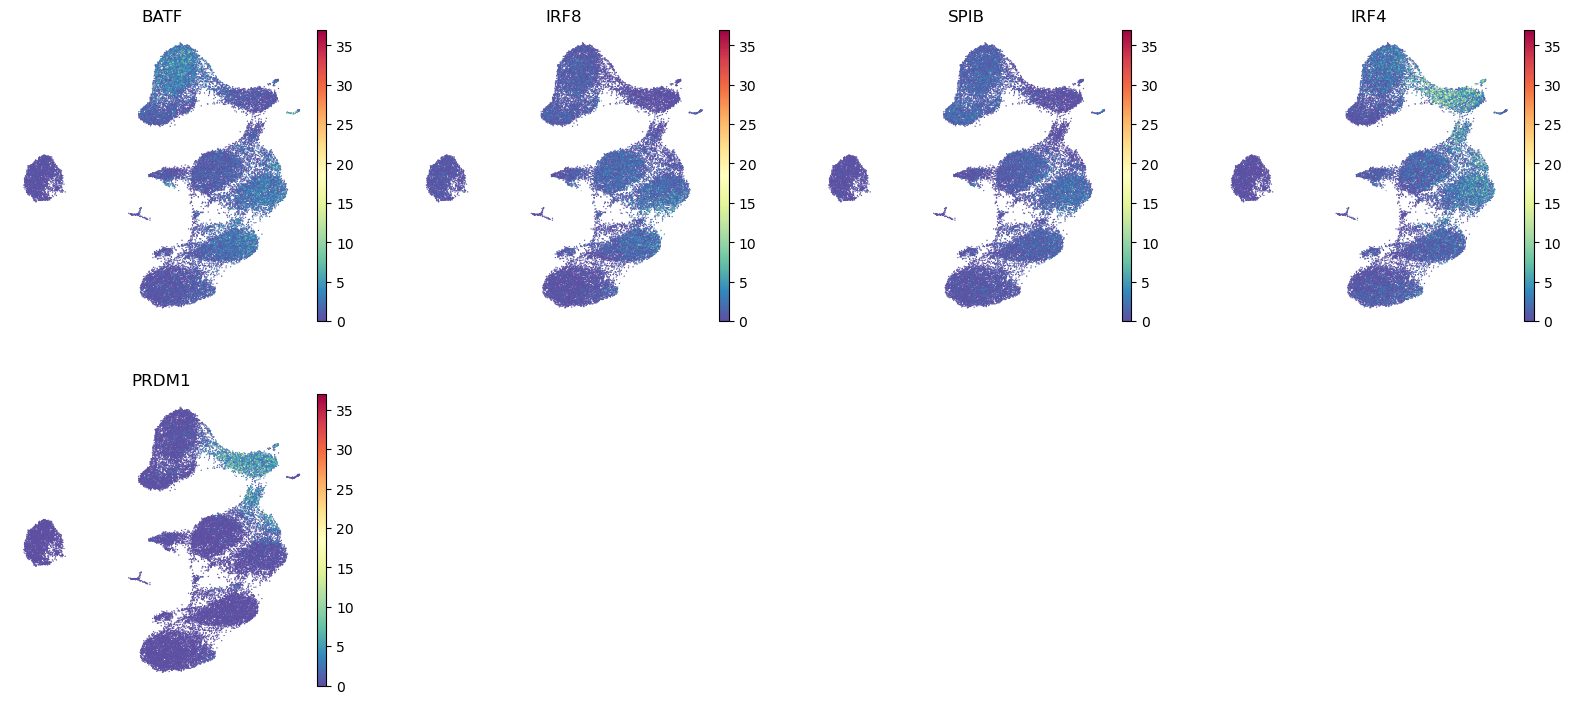

In [67]:
# pre imputation expression of 5 TFs
tf_data = adata_pseudotime[:,TFs_of_importance].X
vmin = np.min(tf_data)
vmax = np.max(tf_data)
sc.pl.embedding(
    adata_pseudotime,
    basis="umap",
    color=["BATF","IRF8","SPIB","IRF4","PRDM1"],
    vmin=vmin,
    vmax=vmax,
    frameon=False,
)
plt.show()

In [68]:
def dim_reduction(adata):
    #Scale before running PCA
    sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    sc.pp.scale(adata, max_value=10)
    sc.pp.pca(adata)
    sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
    return adata

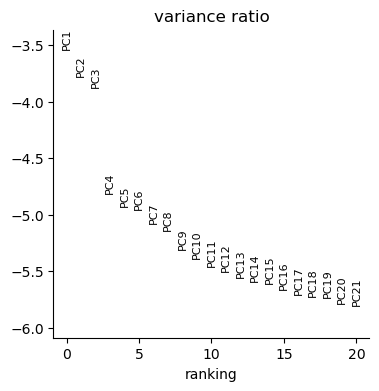

AnnData object with n_obs × n_vars = 32418 × 1533
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'cell_type', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'cell_type_colors', 'sub_cell_type_colors', 'hvg', 'pca'
    obsm: 'X_joint_umap_features', 'X_

In [69]:
adata_pseudotime = dim_reduction(adata_pseudotime)
adata_pseudotime

## Run diffusion maps to get cell-cell similarity/nearest neighbour graphs

In [70]:
dm_res = palantir.utils.run_diffusion_maps(adata_pseudotime,n_components=4)

In [71]:
ms_data = palantir.utils.determine_multiscale_space(adata_pseudotime)

In [72]:
adata_pseudotime

AnnData object with n_obs × n_vars = 32418 × 1533
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'cell_type', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'cell_type_colors', 'sub_cell_type_colors', 'hvg', 'pca', 'DM_EigenValues'
    obsm: 'X_joint_u

#### Plot recalculated nearest neighbours 

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


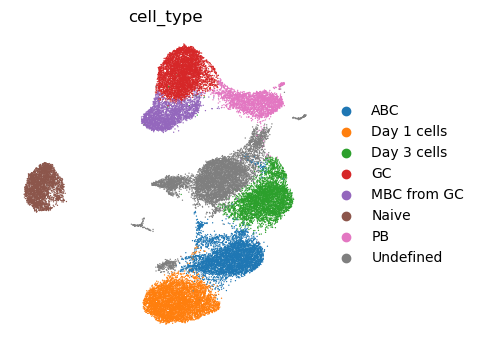

In [74]:
# Use scanpy functions to visualize umaps or FDL
sc.pl.embedding(
    adata_pseudotime,
    basis="umap",
    frameon=False,
    color="cell_type",
)

#### Imputation

In [75]:
imputed_X = palantir.utils.run_magic_imputation(adata_pseudotime)

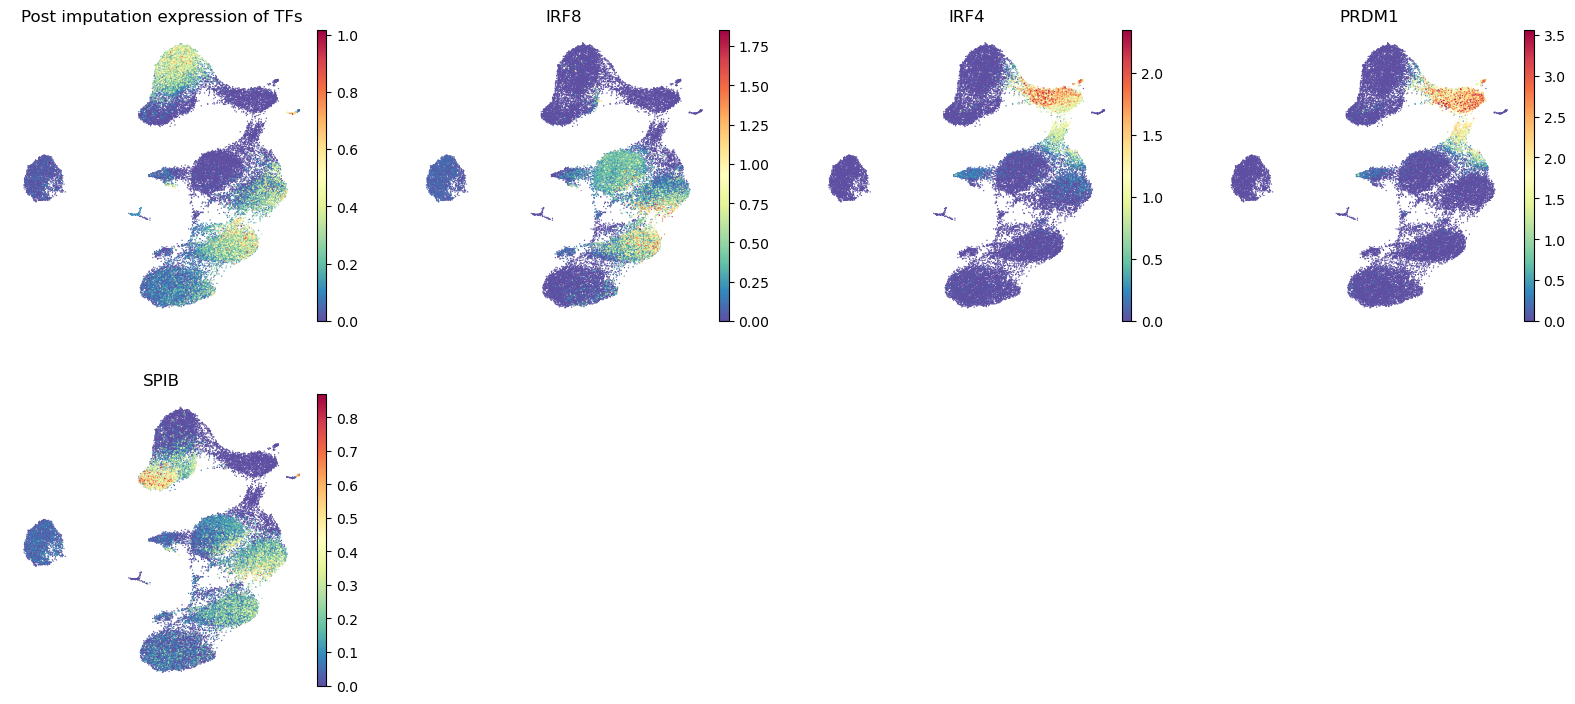

In [76]:
sc.pl.embedding(
    adata_pseudotime,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["BATF","IRF8","IRF4","PRDM1","SPIB"],
    frameon=False,
    title="Post imputation expression of TFs",
)
plt.show()

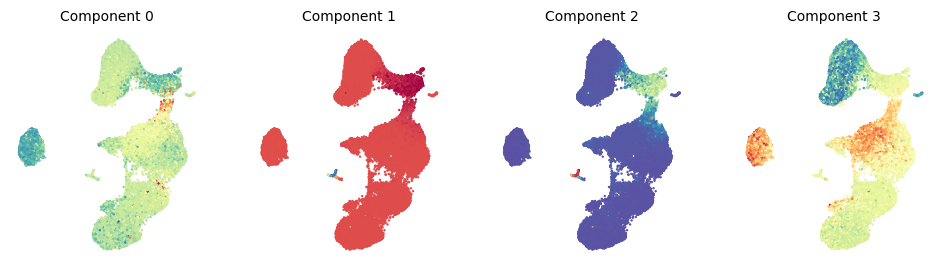

In [77]:
#palantir projects all gene's data to the top diffusion components: to rewigh cell-similarity edges along the direction of high cell density
palantir.plot.plot_diffusion_components(adata_pseudotime)
plt.show()


## Set cells that are terminal and root

In [78]:
GC_cells = adata_pseudotime.obs[adata_pseudotime.obs["cell_type"] == "GC"]
PB_cells = adata_pseudotime.obs[adata_pseudotime.obs["cell_type"] == "PB"]
Naive_cells = adata_pseudotime.obs[adata_pseudotime.obs["cell_type"] == "Naive"]

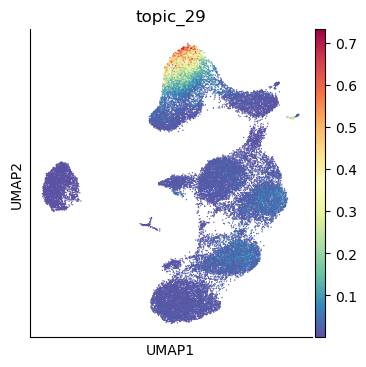

In [79]:
## select which topic to sort cells by to get terminal cell
sc.pl.umap(adata_pseudotime, color=["topic_29"], legend_loc='on data')

In [80]:
#sort GC cell by topic_29
GC_cells = GC_cells.sort_values(by="topic_29")
#print the cell with highest topic_29
terminal_GC = GC_cells.iloc[-1]
terminal_GC

cell_type_major         day5_6
n_genes                   4493
n_genes_by_counts         4491
total_counts           12035.0
total_counts_mt         1351.0
pct_counts_mt        11.225593
topic_0                0.00707
topic_1                0.00924
topic_2               0.005858
topic_3               0.004588
topic_4               0.003929
topic_5               0.013969
topic_6               0.006213
topic_7               0.004032
topic_8               0.006358
topic_9               0.006487
topic_10              0.013193
topic_11               0.00299
topic_12               0.00045
topic_13              0.010002
topic_14               0.00463
topic_15              0.004041
topic_16              0.009481
topic_17              0.003801
topic_18              0.004638
topic_19              0.065933
topic_20              0.000795
topic_21              0.022608
topic_22              0.007652
topic_23              0.007715
topic_24              0.001949
topic_25              0.000845
topic_26

In [81]:
#sort PB cell by topic_27
PB_cells = PB_cells.sort_values(by="topic_27")
#print the cell with highest topic_27
terminal_PB = PB_cells.iloc[-1]
terminal_PB

cell_type_major        day5_6
n_genes                  2813
n_genes_by_counts        2812
total_counts           6754.0
total_counts_mt         520.0
pct_counts_mt        7.699141
topic_0              0.006246
topic_1              0.003973
topic_2              0.002992
topic_3              0.006819
topic_4              0.006258
topic_5              0.006585
topic_6               0.00565
topic_7                0.0057
topic_8               0.00543
topic_9              0.004637
topic_10             0.003062
topic_11             0.006862
topic_12             0.001227
topic_13             0.008143
topic_14             0.046775
topic_15             0.097076
topic_16             0.005793
topic_17             0.004948
topic_18             0.005554
topic_19             0.004869
topic_20             0.001041
topic_21              0.00687
topic_22             0.008506
topic_23              0.00555
topic_24             0.001278
topic_25             0.000932
topic_26             0.142718
topic_27  

In [82]:
#sort Naive cell by topic_20
Naive_cells = Naive_cells.sort_values(by="topic_20")
#print the cell with highest topic_20
start_Naive = Naive_cells.iloc[-1]
start_Naive

cell_type_major        day0_2
n_genes                   925
n_genes_by_counts         924
total_counts           1382.0
total_counts_mt          45.0
pct_counts_mt         3.25615
topic_0              0.003067
topic_1              0.002882
topic_2              0.001833
topic_3              0.003935
topic_4              0.003947
topic_5               0.00322
topic_6              0.003139
topic_7              0.003702
topic_8               0.00278
topic_9              0.003639
topic_10             0.002073
topic_11             0.004814
topic_12             0.000321
topic_13             0.003171
topic_14              0.00325
topic_15             0.002964
topic_16             0.002948
topic_17             0.004471
topic_18             0.003017
topic_19             0.003916
topic_20              0.53303
topic_21             0.003166
topic_22             0.004042
topic_23               0.0051
topic_24             0.000342
topic_25              0.37087
topic_26             0.002751
topic_27  

In [83]:
terminal_states = pd.Series(["GC","PB"], index=["GCTTTACGTACTAAAC-3","ACCTTCATCCTAATTC-3"]) #set call barcode

#### Shortest paths from user defined start and terminal states : initiate pseudotime. Iterative refinement of speudotime to to identify shortest distances of these rotts to 'waypoints' (sets of cells ampled to span the differentitation landscape)

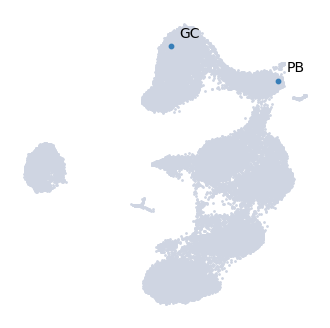

In [84]:
palantir.plot.highlight_cells_on_umap(adata_pseudotime, terminal_states)
plt.show()

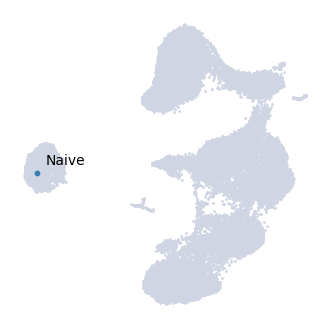

In [85]:
start_cell_plot = pd.Series(["Naive"], index=["TTTCACCCACTTCACT-1"])
palantir.plot.highlight_cells_on_umap(adata_pseudotime, start_cell_plot)
plt.show()

#### Run palantir to calculate pseudotime

In [86]:
start_cell = "TTTCACCCACTTCACT-1"
pr_res = palantir.core.run_palantir(
    adata_pseudotime, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.049433799584706624 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.5390027006467183 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


# Visualize Palantir results

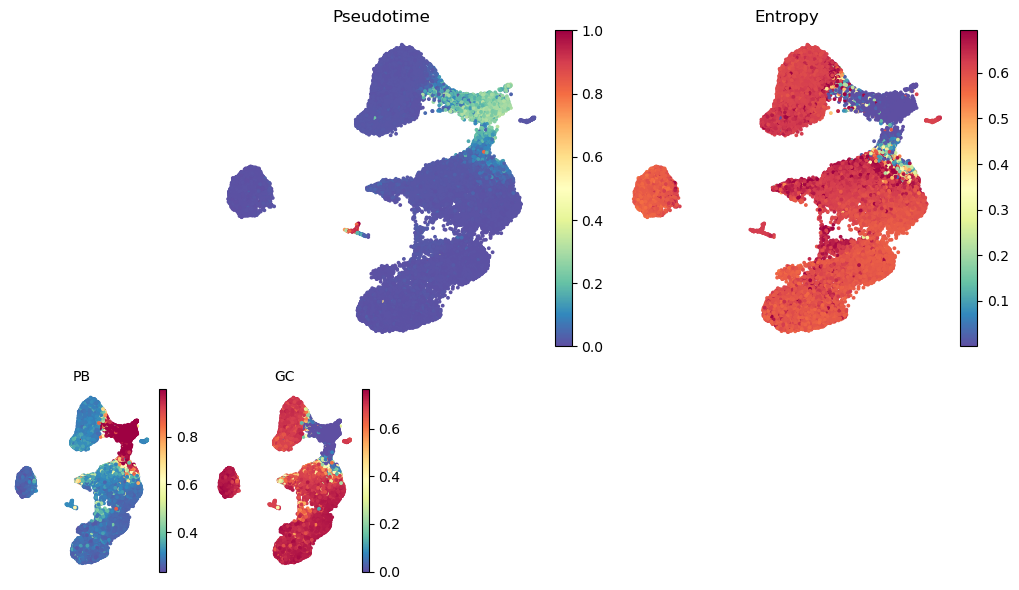

In [87]:
palantir.plot.plot_palantir_results(adata_pseudotime, s=3)
plt.show()

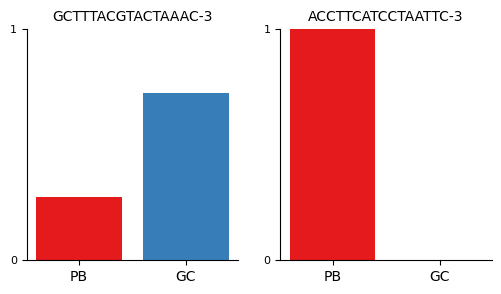

In [54]:
cells = [
    "GCTTTACGTACTAAAC-3",
    "ACCTTCATCCTAATTC-3"
]
palantir.plot.plot_terminal_state_probs(adata_pseudotime, cells)
plt.show()

## Using pseudotime (for directionality) and neighbour graphs to construct markov chain to model differentiation (branch probabilities)

In [55]:
# select branches in trajectory
masks = palantir.presults.select_branch_cells(adata_pseudotime, q=.01, eps=.01)

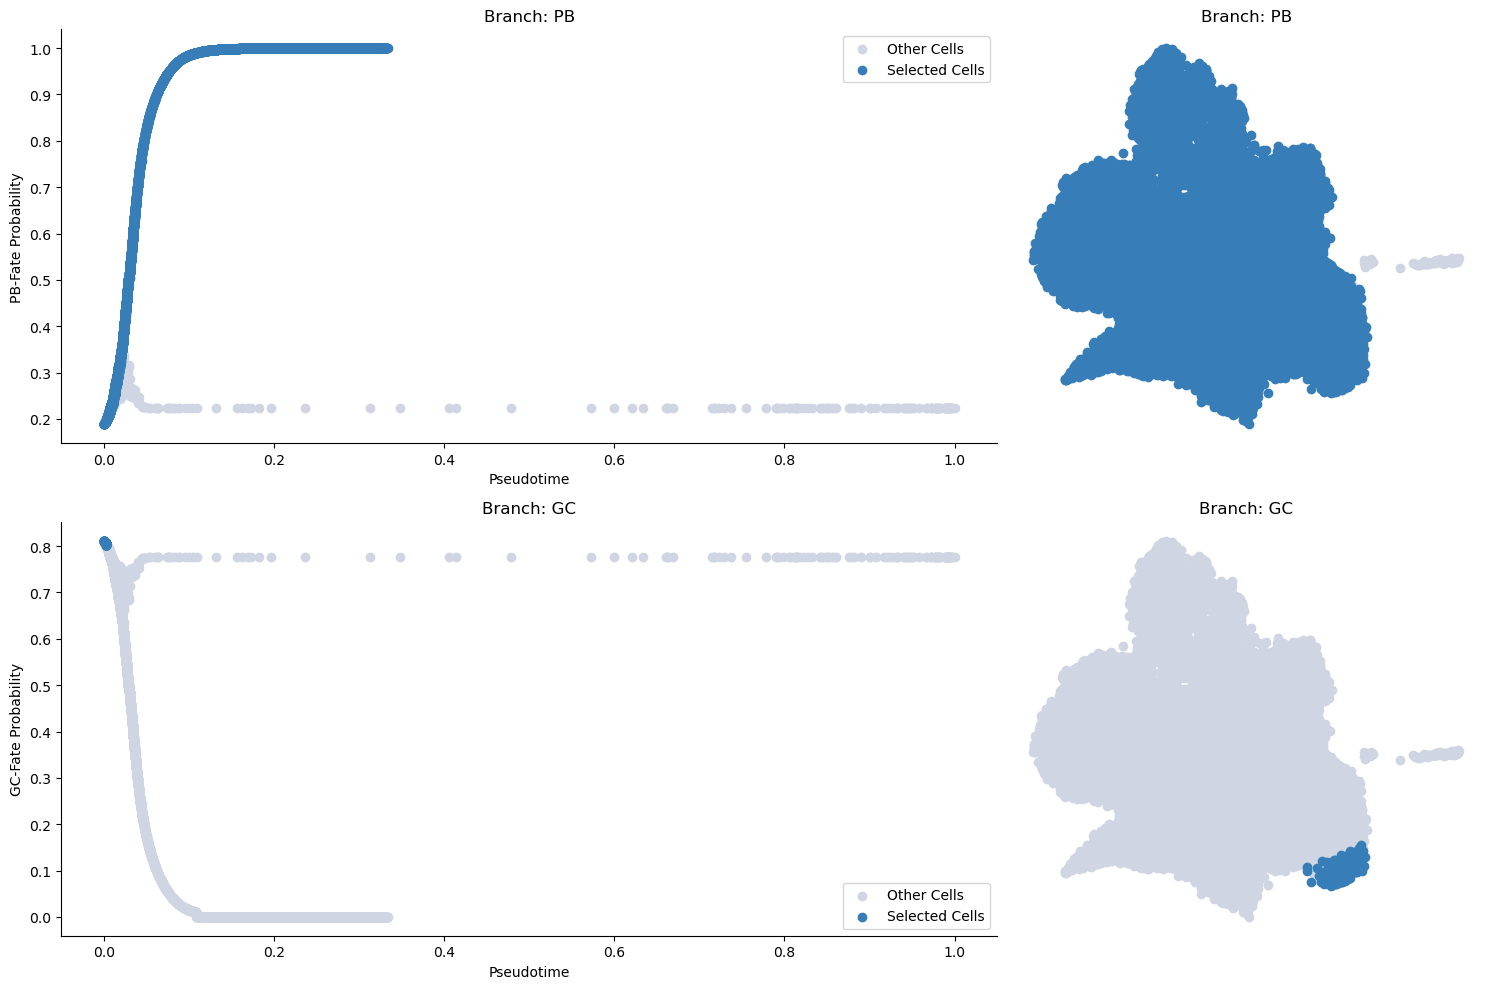

In [56]:
palantir.plot.plot_branch_selection(adata_pseudotime)
plt.show()

[2024-08-05 22:58:41,937] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (32,297) and rank = 1.0.
[2024-08-05 22:58:41,938] [INFO    ] Using covariance function Matern52(ls=1.4971630096435546).
[2024-08-05 22:58:41,939] [INFO    ] Computing 50 landmarks with k-means clustering.


<Axes: title={'center': 'Branch: PB'}, xlabel='UMAP1', ylabel='UMAP2'>

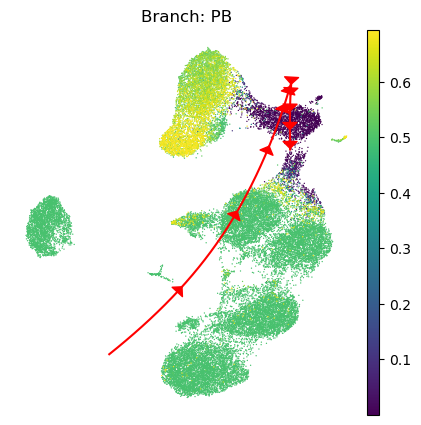

In [90]:
palantir.plot.plot_trajectory(adata_pseudotime, "PB",
    cell_color="palantir_entropy",
    n_arrows=10,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"))

[2024-08-05 22:59:06,557] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (22,141) and rank = 1.0.
[2024-08-05 22:59:06,558] [INFO    ] Using covariance function Matern52(ls=1.4971630096435546).
[2024-08-05 22:59:06,579] [INFO    ] Computing 50 landmarks with k-means clustering.


<Axes: title={'center': 'Branch: GC'}, xlabel='UMAP1', ylabel='UMAP2'>

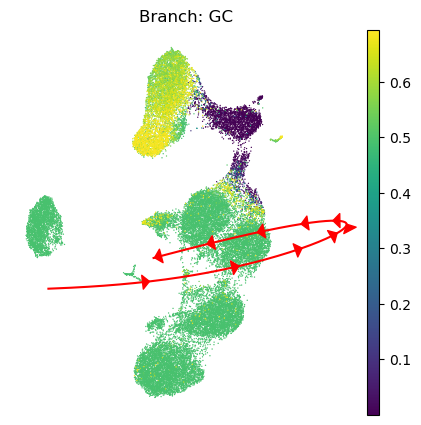

In [91]:
palantir.plot.plot_trajectory(adata_pseudotime, "GC",
    cell_color="palantir_entropy",
    n_arrows=10,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"))

In [92]:
gene_trends = palantir.presults.compute_gene_trends(
    adata_pseudotime,
    expression_key="MAGIC_imputed_data",
)

PB
[2024-08-05 23:00:31,290] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (32,297) and rank = 1.0.
[2024-08-05 23:00:31,290] [INFO    ] Using covariance function Matern52(ls=1.0).
GC
[2024-08-05 23:00:33,715] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (22,141) and rank = 1.0.
[2024-08-05 23:00:33,716] [INFO    ] Using covariance function Matern52(ls=1.0).


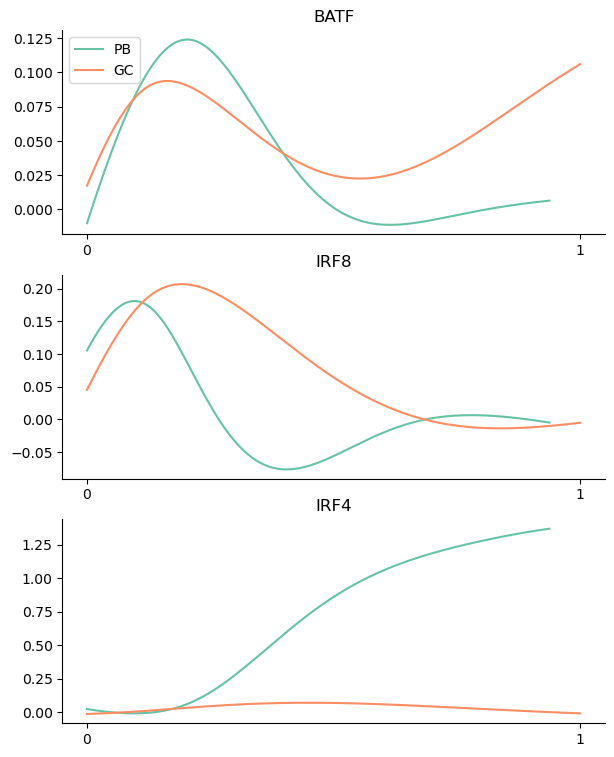

In [95]:
genes = ["BATF", "IRF8", "IRF4"]
palantir.plot.plot_gene_trends(adata_pseudotime, genes)
plt.show()

In [96]:
data_dir_aggr = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr'
file_path = os.path.join(data_dir_aggr, "palantir_gene_leiden_aggr.h5ad")
adata_pseudotime.write(file_path)